In [3]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle as pkl
import numpy as np
import matplotlib

linewidth_in = 3.48761 #inches
textwidth_in = 7.1413
textheight_in = 9.63245

# plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 8
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
sns.set_style("whitegrid")
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


In [4]:
# dirs = ["../logs/0mm_thin_aruco_tracker_test/", "../logs/3mm_thick_step_single/"]
def load_data():
    dirs = ["../logs/2mm_thick_single_shot/", "../logs/3mm_thick_step_single/", "../logs/0mm_thin_aruco_tracker_test/"]
    all_data = {}
    trial_blocks = ["3.0mm step, 0.5 layer", "3.0mm step, 1 layer", "2.0mm step, 1 layer", "4.0mm step, 1 layer", "0.0mm step, 0.5 layer"]
    for j, dir in enumerate(dirs):
        fnames = [dir + f for f in os.listdir(dir) if f.endswith(".pkl") and f.startswith("data")]
        for file in fnames:
            with open(file, "rb") as f:
                df: pd.DataFrame = pkl.load(f)
            thermal_params = df["thermal_estimates"][0].keys()
            for param in thermal_params:
                df[param] = df["thermal_estimates"].apply(lambda x: x[param])
            deflection_params = df["deflection_estimates"][0].keys()
            for param in deflection_params:
                df[param] = df["deflection_estimates"].apply(lambda x: x[param])
            aruco_pos = df["aruco_pos_mm"].to_numpy()
            aruco_pos = np.stack([p:=e if e is not None else p for e in aruco_pos])
            defl = np.linalg.norm(aruco_pos - np.array(df["aruco_pos_mm"][0]), axis=1)
            p = 0
            defl = np.stack([p:=e if e < 10  else p for e in defl])
            df["deflections_mm"] = defl
            df["deflections_mm"] = df["deflections_mm"].rolling(5).mean()
            layers = 1 if "thick" in file else 0.5
            step_size = float(file.split("step")[0].split("mm")[0].split("/")[2].split("_")[-1])
            setup = str(step_size) + "mm step, " + str(layers) + " layer"
            exp_type = "adaptive" if "adaptive" in file else float(file.split("/")[-1].split("_")[1].split("mm")[0])
            trial = 0
            while (setup, exp_type, trial) in all_data.keys():
                trial += 1
            all_data[setup, exp_type, trial] = df
    return all_data


# Metrics

<Figure size 640x480 with 0 Axes>

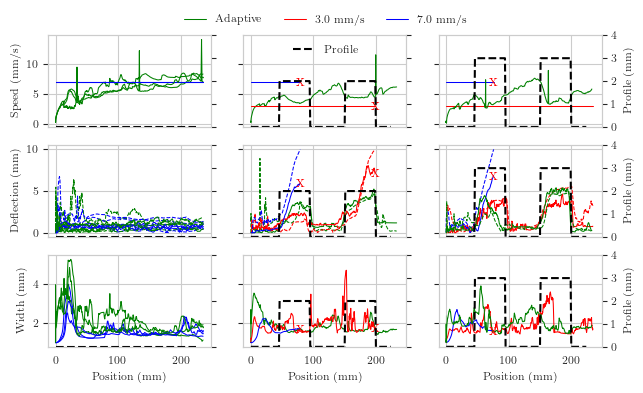

In [20]:
sns.despine()

all_data = load_data()
trial_blocks = np.unique([k[0] for k in all_data.keys()])
fig, axs = plt.subplots(3, len(trial_blocks), sharex=True, sharey="row", figsize=(textwidth_in, 0.42*textheight_in))
profile_axs = np.array([[axs[i, j].twinx() for j in range(3)] for i in range(len(trial_blocks))])
for ax in profile_axs.flatten():
    ax.sharey(profile_axs[0, 0])

for (setup, exp_type, trial), df in all_data.items():
    i = np.where(trial_blocks == setup)[0][0]
    needle_pos = df["position_mm"]

    color = "g" if exp_type == "adaptive" else "b" if exp_type == 7 else "r"
    exp_type = "Adaptive" if exp_type == "adaptive" else str(exp_type) + " mm/s"
    sns.lineplot(data=df, x="position_mm", y="velocities", label=exp_type, ax=axs[0, i], color=color, linewidth=0.75)
    sns.lineplot(data=df, x="position_mm", y="deflections_mm", label=exp_type, ax=axs[1, i], color=color, linewidth=0.75)
    sns.lineplot(data=df, x="position_mm", y="thermal_deflections_mm", ax=axs[1, i], color=color, linestyle='dashed', linewidth=0.75)
    sns.lineplot(data=df, x="position_mm", y="widths_mm", label=exp_type, ax=axs[2, i], color=color, linewidth=0.75)
    if needle_pos.max() < 200:
         anno_args = {
            'ha': 'center',
            'va': 'center',
            'size': 12,
            'color': "r"
         }
         axs[0, i].annotate("x", xy=(needle_pos.max(), df["velocities"][needle_pos.idxmax()]), **anno_args)
         axs[1, i].annotate("x", xy=(needle_pos.max(), df["deflections_mm"][needle_pos.idxmax()]), **anno_args)
         axs[2, i].annotate("x", xy=(needle_pos.max(), df["widths_mm"][needle_pos.idxmax()]), **anno_args)
    step_size = float(setup.split("mm")[0])
    profile = [float(step_size) if 45<i<95 or 150<i<200 else 0 for i in range(225)]

    if len(profile_axs[0, i].lines) == 0:
        sns.lineplot(profile, label="Profile", ax=profile_axs[0, i], color="k", linestyle='dashed', )
        sns.lineplot(profile, label="Profile", ax=profile_axs[1, i], color="k", linestyle='dashed', )
        sns.lineplot(profile, label="Profile", ax=profile_axs[2, i], color="k", linestyle='dashed', )

    # profile_ax.set_ylabel("Profile (mm)")
    # axs[0, i].legend()
    axs[0, i].set_ylabel("Speed (mm/s)")
    axs[1, i].set_ylabel("Deflection (mm)")
    axs[2, i].set_ylabel("Width (mm)")
    axs[2, i].set_xlabel("Position (mm)")
    # handles, labels = axs[0, i].get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # axs[0, i].legend(*zip(*unique))
for ax in axs.flatten():
    ax.get_legend().remove()
for ax in profile_axs.flatten():
    ax.get_legend().remove()

axs[0, 1].legend(title="Experiment Type")
sns.move_legend(
    axs[0, 1], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
profile_axs[0, 0].set_ylim(0, 4)
for row in range(3):
    profile_axs[row, 2].set_ylabel("Profile (mm)")
    profile_axs[row, 2].tick_params(labelright=True)
    profile_axs[row, 2].grid(None)
for row in range(3):
    profile_axs[row, 0].tick_params(labelright=False)
    profile_axs[row, 1].tick_params(labelright=False)
    profile_axs[row, 0].grid(None)
    profile_axs[row, 1].grid(None)


profile_axs[0, 1].legend(title="Profile")
sns.move_legend(
    profile_axs[0,1], "upper center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.savefig("metrics.pgf")
plt.show()
plt.close('all')

# Parameters

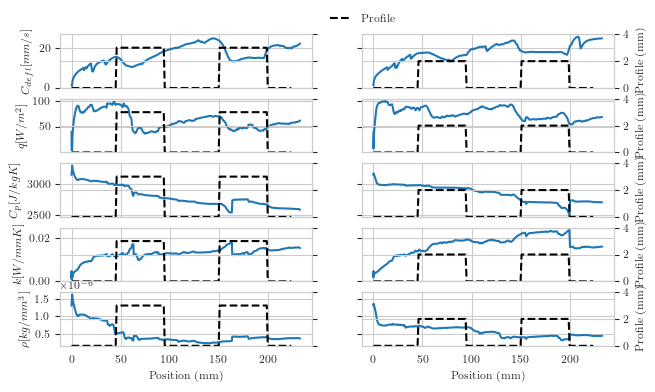

In [21]:
all_data = load_data()

fig, axs = plt.subplots(5, len(trial_blocks)-1, sharex=True, sharey="row", figsize=(textwidth_in, 0.42*textheight_in))
profile_axs = np.array([[axs[i, j].twinx() for j in range(2)] for i in range(5)])
for ax in profile_axs.flatten():
    ax.sharey(profile_axs[0, 0])

for (setup, exp_type, trial), df in all_data.items():
    if exp_type != "adaptive" or "0.0mm" in setup:
        continue
    i = np.where(trial_blocks == setup)[0][0] % 2
    sns.lineplot(data=df, x="position_mm", y="c_defl", label="c_defl [mm/s]", ax=axs[0, i])
    axs[0, i].set_ylabel(r"$C_{defl} [mm/s]$")
    sns.lineplot(data=df, x="position_mm", y="q", label="q [W/m^2]", ax=axs[1, i])
    axs[1, i].set_ylabel(r"$q [W/m^2]$")
    sns.lineplot(data=df, x="position_mm", y="Cp", label="Cp [J/kgK]", ax=axs[2, i])
    axs[2, i].set_ylabel(r"$C_p [J/kgK]$")
    sns.lineplot(data=df, x="position_mm", y="k", label="k [W/mmK]", ax=axs[3, i])
    axs[3, i].set_ylabel(r"$k [W/mmK]$")
    sns.lineplot(data=df, x="position_mm", y="rho", label="rho [kg/mm^3]", ax=axs[4, i])
    axs[4, i].set_ylabel(r"$\rho [kg/mm^3]$")

    step_size = float(setup.split("mm")[0])
    profile = [float(step_size) if 45<i<95 or 150<i<200 else 0 for i in range(225)]
    if len(profile_axs[0, i].lines) == 0:
        sns.lineplot(profile, label="Profile", ax=profile_axs[0, i], color="k", linestyle='dashed')
        sns.lineplot(profile, label="Profile", ax=profile_axs[1, i], color="k", linestyle='dashed')
        sns.lineplot(profile, label="Profile", ax=profile_axs[2, i], color="k", linestyle='dashed')
        sns.lineplot(profile, label="Profile", ax=profile_axs[3, i], color="k", linestyle='dashed')
        sns.lineplot(profile, label="Profile", ax=profile_axs[4, i], color="k", linestyle='dashed')

for ax in axs.flatten():
    ax.get_legend().remove()
    ax.set_xlabel(r"Position (mm)")
for ax in profile_axs.flatten():
    ax.get_legend().remove()

profile_axs[0, 0].set_ylim(0, 4)
for row in range(5):
    profile_axs[row, 1].set_ylabel("Profile (mm)")
    profile_axs[row, 1].tick_params(labelright=True)
for row in range(5):
    profile_axs[row, 0].tick_params(labelright=False)


profile_axs[0, 1].legend(title="Profile")
sns.move_legend(
    profile_axs[0,1], "lower center",
    bbox_to_anchor=(0, 1), ncol=3, title=None, frameon=False)
plt.savefig("params.pgf")
plt.show()
plt.close('all')

# Step Response

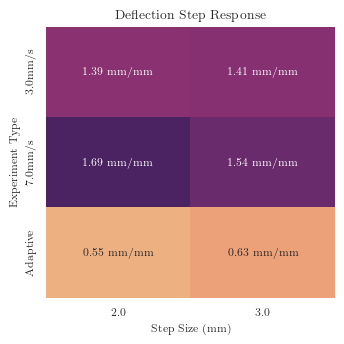

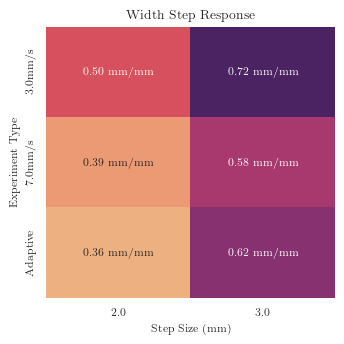

In [7]:
all_data = load_data()

def step_response(step_size, output, step_loc, step_length):
    return np.mean(output[step_loc:step_loc+step_length]) - np.mean(output[:step_loc]) / step_size

adaptive_step_responses = []
constant_step_responses = []

defl_step_response_df = pd.DataFrame(columns=["Setup", "Experiment Type", "Trial", "Deflection Step Response"])
width_step_response_df = pd.DataFrame(columns=["Setup", "Experiment Type", "Trial", "Width Step Response"])

for (setup, exp_type, trial), df in all_data.items():
    step_size = float(setup.split("mm")[0])
    if step_size == 0:
        continue
    profile = [step_size if 45 < df["position_mm"][i] < 95 else 0 for i in range(len(df))]
    step_loc = np.where(np.array(profile) == step_size)[0][0]
    step_length = np.where(np.array(profile) == step_size)[0][-1] - step_loc
    widths = df["widths_mm"]
    deflections = df["deflections_mm"]
    width_step_response = step_response(step_size, widths, step_loc, step_length)
    deflection_step_response = step_response(step_size, deflections, step_loc, step_length)
    setup = setup.split("mm")[0]
    exp_type = str(exp_type) + "mm/s" if exp_type != "adaptive" else "Adaptive"
    defl_step_response_df.loc[len(defl_step_response_df)] = [setup, exp_type, trial, deflection_step_response]
    width_step_response_df.loc[len(width_step_response_df)] = [setup, exp_type, trial, width_step_response]

    # redo for second step in profile
    profile = [step_size if 150 < df["position_mm"][i] < 200 else 0 for i in range(len(df))]
    profile = profile[step_loc+step_length:]
    if np.where(np.array(profile) == step_size)[0].size == 0:
        continue
    step_loc = np.where(np.array(profile) == step_size)[0][0]
    step_length = np.where(np.array(profile) == step_size)[0][-1] - step_loc
    widths = widths[step_loc+step_length:]
    deflections = deflections[step_loc+step_length:]
    width_step_response = step_response(step_size, widths, step_loc, step_length)
    deflection_step_response = step_response(step_size, deflections, step_loc, step_length)
    defl_step_response_df.loc[len(defl_step_response_df)] = [setup, exp_type, trial, deflection_step_response]
    width_step_response_df.loc[len(width_step_response_df)] = [setup, exp_type, trial, width_step_response]

defl_summary_table = defl_step_response_df.groupby(["Setup", "Experiment Type"]).mean().unstack().T
defl_summary_table.index = defl_summary_table.index.droplevel(0)
defl_summary_table = defl_summary_table.groupby("Experiment Type").mean()

width_summary_table = width_step_response_df.groupby(["Setup", "Experiment Type"]).mean().unstack().T
width_summary_table.index = width_summary_table.index.droplevel(0)
width_summary_table = width_summary_table.groupby("Experiment Type").mean()

# create heatmap with number of samples next to the value
fig, ax = plt.subplots(figsize=(linewidth_in, linewidth_in))
sns.heatmap(defl_summary_table, annot=True, fmt=".2f", ax=ax, cmap=sns.color_palette("flare", as_cmap=True), cbar=False)
for t in ax.texts:
    t.set_text(t.get_text() + " mm/mm")
ax.set_xlabel("Step Size (mm)")
ax.set_ylabel("Experiment Type")
plt.title("Deflection Step Response")
fig.tight_layout()
plt.savefig("defl_step_response.pgf")

fig, ax = plt.subplots(figsize=(linewidth_in, linewidth_in))
sns.heatmap(width_summary_table, annot=True, fmt=".2f", ax=ax, cmap=sns.color_palette("flare", as_cmap=True), cbar=False)
for t in ax.texts: t.set_text(t.get_text() + " mm/mm")
ax.set_xlabel("Step Size (mm)")
ax.set_ylabel("Experiment Type")
plt.title("Width Step Response")
fig.tight_layout()

In [8]:

plt.savefig("width_step_response.pgf")
plt.show()
plt.close('all')


<Figure size 640x480 with 0 Axes>

# Success rate

In [9]:
dirs = ["../logs/2mm_thick_single_shot/", "../logs/3mm_thick_step_single/", "../logs/0mm_thin_aruco_tracker_test/", "../logs/2mm_thick_step/", "../logs/3mm_thick_step/", "../logs/3mm_step/"]
all_data = {}
trial_blocks = ["3.0mm step, 0.5 layer", "3.0mm step, 1 layer", "2.0mm step, 1 layer", "4.0mm step, 1 layer", "0.0mm step, 0.5 layer"]
for j, dir in enumerate(dirs):
    fnames = [dir + f for f in os.listdir(dir) if f.endswith(".pkl") and f.startswith("data")]
    for file in fnames:
        with open(file, "rb") as f:
            df: pd.DataFrame = pkl.load(f)
        thermal_params = df["thermal_estimates"][0].keys()
        for param in thermal_params:
            df[param] = df["thermal_estimates"].apply(lambda x: x[param])
        deflection_params = df["deflection_estimates"][0].keys()
        for param in deflection_params:
            df[param] = df["deflection_estimates"].apply(lambda x: x[param])
        layers = 1 if "thick" in file else 0.5
        step_size = float(file.split("step")[0].split("mm")[0].split("/")[2].split("_")[-1])
        setup = str(step_size) + "mm step, " + str(layers) + " layer"
        exp_type = "adaptive" if "adaptive" in file else float(file.split("/")[-1].split("_")[1].split("mm")[0])
        trial = 0
        while (setup, exp_type, trial) in all_data.keys():
            trial += 1
        all_data[setup, exp_type, trial] = df


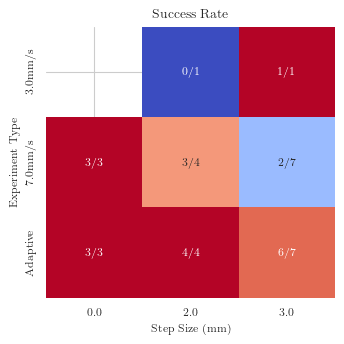

In [10]:
success_table = pd.DataFrame(columns=["Setup", "Experiment Type", "Success"])
for i, ((setup, exp_type, _), df) in enumerate(all_data.items()):
    success = df["position_mm"].max() > 200
    setup = setup.split("mm")[0]
    exp_type = str(exp_type) + "mm/s" if exp_type != "adaptive" else "Adaptive"
    success_table.loc[len(success_table)] = [setup, exp_type, success]

## Table with y axis exp_type and x axis setup, and success rate as a fraction
success_table["Success"] = success_table["Success"].astype(int)
summary_table = success_table.groupby(["Setup", "Experiment Type"]).mean().unstack().T
n = success_table.groupby(["Setup", "Experiment Type"]).count().unstack().T
summary_table.index = summary_table.index.droplevel(0)
n.index = n.index.droplevel(0)
annot = np.empty_like(summary_table, dtype=object)
indices = summary_table.index
columns = summary_table.columns
for setup, exp_type in itertools.product(columns, indices):
    i = indices.get_loc(exp_type)
    j = columns.get_loc(setup)
    denominator = n[setup][exp_type]
    numerator = summary_table[setup][exp_type]
    if np.isnan(numerator) or np.isnan(denominator):
        annot[i, j] = ""
    else:
        denominator = int(denominator)
        numerator = int(numerator * denominator)
        annot[i, j] = f"{numerator:d}/{denominator:d}"
# create heatmap
fig, ax = plt.subplots(figsize=(linewidth_in, linewidth_in))
sns.heatmap(summary_table, annot=annot, ax=ax, cmap="coolwarm", cbar=False, fmt='')
ax.set_xlabel("Step Size (mm)")
ax.set_ylabel("Experiment Type")
plt.title("Success Rate")
fig.tight_layout()
plt.show()

In [11]:
plt.savefig("success.pgf")
plt.close('all')

Combine the three plots above into one plot

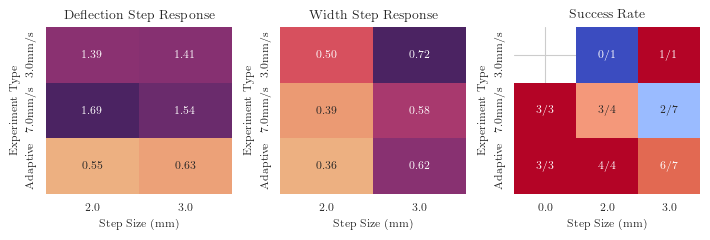

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(textwidth_in, 0.7*linewidth_in))
sns.despine()
sns.heatmap(defl_summary_table, annot=True, fmt=".2f", ax=axs[0], cmap=sns.color_palette("flare", as_cmap=True), cbar=False)
axs[0].set_xlabel("Step Size (mm)")
axs[0].set_ylabel("Experiment Type")
axs[0].set_title("Deflection Step Response")
sns.heatmap(width_summary_table, annot=True, fmt=".2f", ax=axs[1], cmap=sns.color_palette("flare", as_cmap=True), cbar=False)
axs[1].set_xlabel("Step Size (mm)")
axs[1].set_ylabel("Experiment Type")
axs[1].set_title("Width Step Response")
sns.heatmap(summary_table, annot=annot, ax=axs[2], cmap="coolwarm", cbar=False, fmt='')
axs[2].set_xlabel("Step Size (mm)")
axs[2].set_ylabel("Experiment Type")
axs[2].set_title("Success Rate")
fig.tight_layout()
plt.savefig("combined.pgf")
plt.show()
plt.close('all')